In [3]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [5]:
class Discriminator(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.disc = nn.Sequential(
            nn.Linear(in_features,128),
            nn.LeakyReLU(0.1),
            nn.Linear(128,1),
            nn.Sigmoid(),
                 )
    def forward(self,x):
        return self.disc(x)

In [11]:
class generator(nn.Module):
    def __init__(self,z_dim,img_dim):
        super().__init__()
        self.gen = nn.Sequential(
            nn.Linear(z_dim,256),
            nn.LeakyReLU(0.1),
            nn.Linear(256,img_dim),
            nn.Tanh()
        )
    def forward(self,x):
        return self.gen(x)

In [8]:
#hyperparameters 

device = "cuda" if torch.cuda.is_available() else "cpu"
lr = 3e-4
z_dim = 64 #128,256
image_dim = 28*28*1
batch_size = 32
num_epochs = 50


In [13]:
disc = Discriminator(image_dim).to(device)
gen = generator(z_dim,image_dim).to(device)
fixed_noise = torch.randn((batch_size,z_dim)).to(device)
transforms = transforms.Compose(
    [transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,))]  
)


In [14]:
dataset = datasets.MNIST(root="datasets/",transform = transforms,download=True)

100%|██████████| 9912422/9912422 [00:10<00:00, 931562.26it/s] 


Extracting datasets/MNIST\raw\train-images-idx3-ubyte.gz to datasets/MNIST\raw



100%|██████████| 28881/28881 [00:00<00:00, 14457058.58it/s]


Extracting datasets/MNIST\raw\train-labels-idx1-ubyte.gz to datasets/MNIST\raw



100%|██████████| 1648877/1648877 [00:01<00:00, 941587.36it/s] 


Extracting datasets/MNIST\raw\t10k-images-idx3-ubyte.gz to datasets/MNIST\raw



100%|██████████| 4542/4542 [00:00<00:00, 4546665.58it/s]

Extracting datasets/MNIST\raw\t10k-labels-idx1-ubyte.gz to datasets/MNIST\raw



In [15]:
loader = DataLoader(dataset,batch_size=batch_size,shuffle=True)


In [18]:
opt_disc = optim.Adam(disc.parameters(),lr=lr)
opt_gen = optim.Adam(gen.parameters(),lr=lr)
criterion = nn.BCELoss()


In [23]:
for epoch in range(num_epochs):
    print(epoch)
    for batch_idx , (real,_) in enumerate(loader):
        real = real.view(-1,784).to(device)
        batch_size = real.shape[0]
        
        #train discriminator 
        noise = torch.randn(batch_size,z_dim).to(device)
        fake = gen(noise)
        disc_real = disc(real).view(-1)
        lossD_real = criterion(disc_real,torch.ones_like(disc_real)) #we are passing ones because for generator the sample should be 1
        disc_fake = disc(fake).view(-1)
        lossD_fake = criterion(disc_fake,torch.zeros_like(disc_fake))
        lossD = (lossD_fake + lossD_real) / 2
        disc.zero_grad()
        lossD.backward(retain_graph = True)  #to utalise fake not to clear intermediate calculations to save space
        opt_disc.step()

        ### train generator min log(1-D(G(z))) <--> max log(D(G(z)))

        output = disc(fake).view(-1)
        lossG = criterion(output,torch.ones_like(output))
        gen.zero_grad()
        lossG.backward()
        opt_gen.step()
        
        if batch_idx == 0 :
            print(
                f"Epoch [{epoch}/{num_epochs}] \ "
                f"Loss D : {lossD:.4f} , Loss G : {lossG:.4f}"
            )
        


         




0
Epoch [0/50] \ Loss D : 0.7123 , Loss G : 0.8345
1
Epoch [1/50] \ Loss D : 0.6802 , Loss G : 0.8400
2
Epoch [2/50] \ Loss D : 0.4336 , Loss G : 1.3010
3
Epoch [3/50] \ Loss D : 0.5309 , Loss G : 1.2715
4
Epoch [4/50] \ Loss D : 0.3962 , Loss G : 1.7711
5
Epoch [5/50] \ Loss D : 0.7762 , Loss G : 0.7763
6
Epoch [6/50] \ Loss D : 0.5924 , Loss G : 1.1500
7
Epoch [7/50] \ Loss D : 0.7231 , Loss G : 0.9384
8
Epoch [8/50] \ Loss D : 0.7999 , Loss G : 0.9572
9
Epoch [9/50] \ Loss D : 0.5091 , Loss G : 1.2690
10
Epoch [10/50] \ Loss D : 0.7187 , Loss G : 0.9344
11
Epoch [11/50] \ Loss D : 0.6829 , Loss G : 1.0846
12
Epoch [12/50] \ Loss D : 0.6159 , Loss G : 1.1650
13
Epoch [13/50] \ Loss D : 0.6599 , Loss G : 1.1025
14
Epoch [14/50] \ Loss D : 0.6190 , Loss G : 1.0958
15
Epoch [15/50] \ Loss D : 0.5161 , Loss G : 1.2677
16
Epoch [16/50] \ Loss D : 0.6251 , Loss G : 1.1740
17
Epoch [17/50] \ Loss D : 0.6581 , Loss G : 0.8441
18
Epoch [18/50] \ Loss D : 0.5084 , Loss G : 1.4761
19
Epoch [19/

In [33]:
z = torch.randn(batch_size, z_dim)

In [34]:
generated_images = gen(z)

In [36]:
generated_images.shape

torch.Size([32, 784])

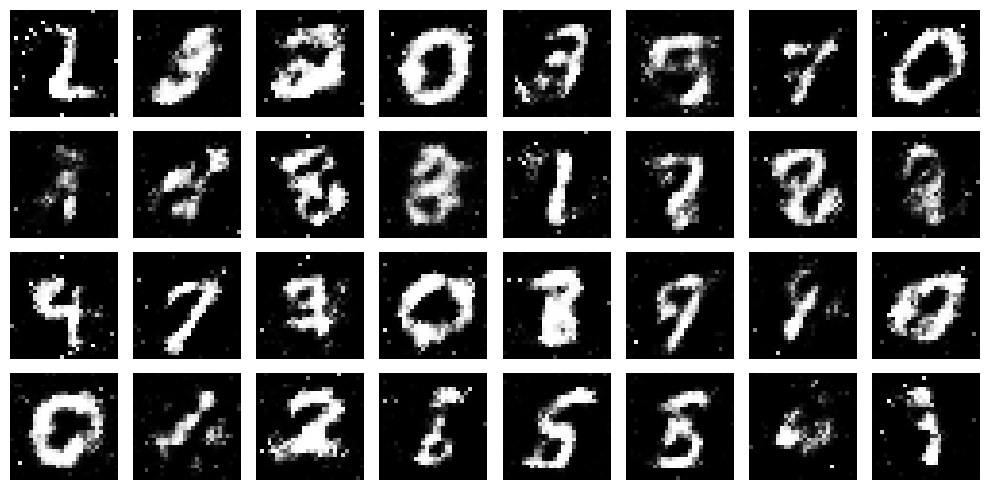

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming generated_images is a tensor of shape (batch_size, 784)
# Reshape each image to its original dimensions (28x28)
generated_images = generated_images.view(-1, 28, 28)

# Convert the tensor to a numpy array
generated_images = generated_images.detach().numpy()

# Plot the images
fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(10, 5))

for i, ax in enumerate(axes.flatten()):
    ax.imshow(generated_images[i], cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.show()


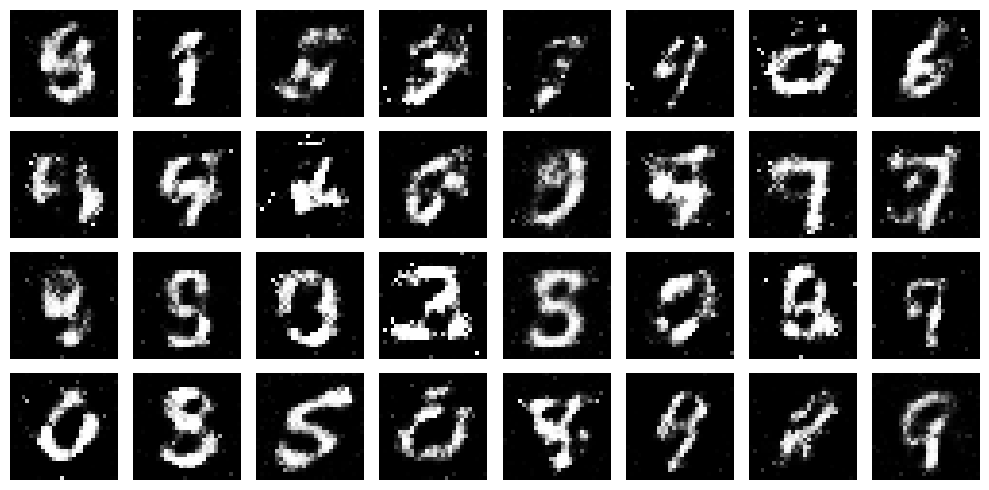

In [40]:
y = torch.randn(batch_size, z_dim)
generated_images = gen(y)

generated_images = generated_images.view(-1, 28, 28)

# Convert the tensor to a numpy array
generated_images = generated_images.detach().numpy()

# Plot the images
fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(10, 5))

for i, ax in enumerate(axes.flatten()):
    ax.imshow(generated_images[i], cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.show()


In [42]:
generator_model_path = "generator_model.pth"
torch.save(gen, generator_model_path)

In [43]:
generator = torch.load(generator_model_path)

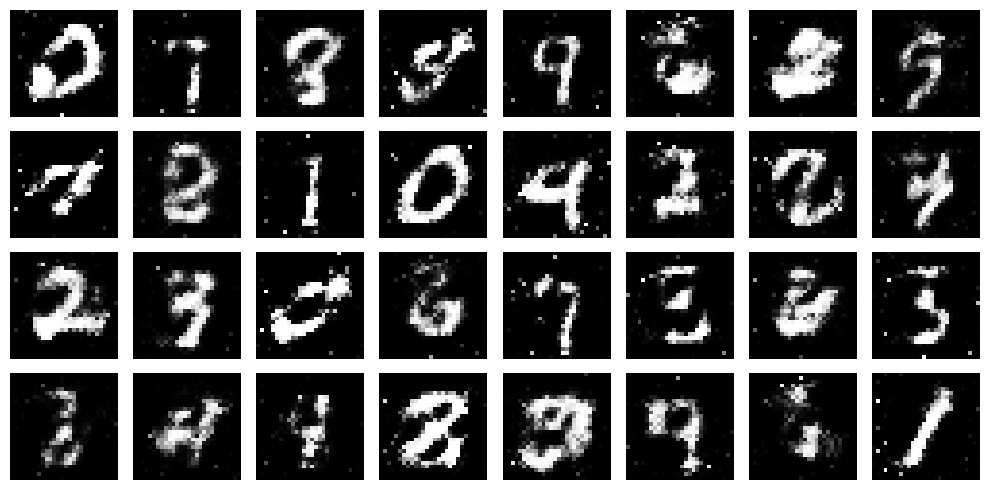

In [44]:
y = torch.randn(batch_size, z_dim)
generated_images = generator(y)

generated_images = generated_images.view(-1, 28, 28)

# Convert the tensor to a numpy array
generated_images = generated_images.detach().numpy()

# Plot the images
fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(10, 5))

for i, ax in enumerate(axes.flatten()):
    ax.imshow(generated_images[i], cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.show()
